In [1]:
n_vars=30

# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/" 
# se_meta = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/anno_mt_af_v02/input/method_bias"
# method = "bias"

method = "bias"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_nuclear/variants_prefilterMerge_impute/method_bias/"
indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/"
se_meta = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"



conditions = None #"Input"
top_n = 50




In [2]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm



In [3]:
import mplh.cluster_help as ch
import mplh.fig_utils as fu
from mplh.color_utils import create_color_df_v02


fig_utils from mplh


In [4]:
from colorcet.plotting import swatch, swatches, candy_buttons
import colorcet as cc
#import holoviews as hv
# hv.extension('bokeh')

### Smaller params

In [5]:
don_dirs = [d for d in glob(indir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor1'}

In [6]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    variants = set(af.columns)
    return af, cov, variants


In [7]:
af_d = {}
cov_d = {}
for d in don_dirs: 
    curr_af, curr_cov, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    #curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    af_d[d] = curr_af
    cov_d[d] = curr_cov

In [8]:
# append any unseen variants in different donors
allVars = [set(af_d[d].columns) for d in af_d]
allVars = allVars[0].union(*allVars)
len(allVars)

for d in af_d:
    unseen_cols = allVars - set(af_d[d].columns.values)
    print('unseen_cols')
    print(unseen_cols)
    print(len(unseen_cols))
    af_d[d].loc[:, unseen_cols] = 0
    cov_d[d].loc[:, unseen_cols] = 0

unseen_cols
{'13879C', '13188T', '64T', '15497A', '8292A', '8461T', '146C', '827G', '10397G', '16355T', '196C', '11761T', '2521G', '204C', '16362C', '58C', '14905C', '5442C', '3735G', '1040C', '8770T', '13327C', '15452G', '7598A', '15297C', '11838A', '983T', '2442C', '10589A', '3630A', '16189C', '3847C', '13327G', '5273T'}
34
unseen_cols
{'4216C', '11711A', '146A', '4117G', '4917G', '7485C', '1888A', '14233C', '2857A', '11453A', '15928A', '14674C', '16304C', '13368A', '11812G', '5580C', '2857G', '4117C', '8743A', '15607G', '2442A', '2445C', '152C', '7485T', '16519G', '15452A', '15244C', '13369C', '8697A', '10463C', '1413C', '1413A', '1201C', '3820A', '2857C', '930A', '1082G', '14905A', '5147A', '11719A', '189G', '10559G', '709A', '16294T', '7639T', '16519C', '14488C', '2623T', '14233G', '7485G', '15244G'}
51


In [9]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()



(13593, 41)
(12188, 41)


,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGGAGACTC-1_Flt3l,Flt3l,531,531,2286,298,7,7,124,749,1101,...,649,621,Flt3l_AAACGAAAGGAGACTC-1,0.0,AAACGAAAGGAGACTC-1,1.0,Flt3l,1,1.0,Neutrophil
AAACGAAAGTCACGCC-1_Flt3l,Flt3l,1222,1222,4711,555,16,12,289,853,2986,...,1674,1502,Flt3l_AAACGAAAGTCACGCC-1,1.0,AAACGAAAGTCACGCC-1,2.0,Flt3l,1,2.0,Erythrocyte
AAACGAACAAGACTAA-1_Flt3l,Flt3l,2225,2225,9178,1509,37,19,585,1339,5689,...,3369,2695,Flt3l_AAACGAACAAGACTAA-1,2.0,AAACGAACAAGACTAA-1,3.0,Flt3l,1,3.0,Neutrophil
AAACGAACAAGCGAAC-1_Flt3l,Flt3l,2271,2271,8825,1544,24,24,535,1308,5390,...,3360,2784,Flt3l_AAACGAACAAGCGAAC-1,3.0,AAACGAACAAGCGAAC-1,4.0,Flt3l,0,1.0,Granulocyte
AAACGAACACAGCCAC-1_Flt3l,Flt3l,2854,2854,10589,1294,41,31,456,2764,6003,...,3722,2998,Flt3l_AAACGAACACAGCCAC-1,4.0,AAACGAACACAGCCAC-1,5.0,Flt3l,0,2.0,Non-classical monocyte


In [10]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

if "cluster_labels" in labels_df.columns:
    labels_df["labels"] = labels_df["cluster_labels"]
elif "labels" in labels_df.columns:
    pass
elif "seurat_clusters" in labels_df.columns:
    labels_df["labels"] = labels_df["seurat_clusters"]
   

(13593, 41)
(12188, 41)


In [11]:
color_d={x:cc.cm.glasbey_dark.colors[ind] for ind, x in enumerate(np.sort(labels_df["labels"].unique()))} 

In [12]:
if conditions != None and conditions != "None":
    conditions_l = conditions.split(",")
    labels_df = labels_df.loc[labels_df["condition"].isin(conditions_l)]
    print(labels_df.shape)

## Group by labels and donor 

In [13]:
all_cells=[]
for d in af_d:
    all_cells.extend(af_d[d].index.values)
all_cells = set(all_cells) #set([af_d[d].index.values for d in af_d])

print(labels_df.shape)
labels_df = labels_df[labels_df.index.isin(all_cells)]
print(labels_df.shape)

(12188, 42)
(6280, 42)


In [14]:
labels_df

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels,labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAGTCTGATTG-1_Flt3l,Flt3l,4239,4239,15047,1940,50,52,636,4173,8196,...,4119,Flt3l_AAACGAAGTCTGATTG-1,10.0,AAACGAAGTCTGATTG-1,11.0,Flt3l,0,6.0,HSPC 3,HSPC 3
AAACTCGGTAGGTCTT-1_Flt3l,Flt3l,2925,2925,13052,1674,43,26,526,4014,6769,...,3532,Flt3l_AAACTCGGTAGGTCTT-1,25.0,AAACTCGGTAGGTCTT-1,26.0,Flt3l,1,12.0,Erythrocyte,Erythrocyte
AAAGGGCAGACTTCCA-1_Flt3l,Flt3l,3562,3562,14297,2199,46,34,695,3497,7826,...,3642,Flt3l_AAAGGGCAGACTTCCA-1,97.0,AAAGGGCAGACTTCCA-1,98.0,Flt3l,0,52.0,Classical Monocyte,Classical Monocyte
AAATGAGGTATCCTTT-1_Flt3l,Flt3l,4915,4915,16671,2497,75,62,760,2906,10371,...,4673,Flt3l_AAATGAGGTATCCTTT-1,126.0,AAATGAGGTATCCTTT-1,127.0,Flt3l,0,66.0,Non-classical monocyte,Non-classical monocyte
AAATGCCGTGATAAGT-1_Flt3l,Flt3l,3886,3886,15323,2276,44,49,723,3740,8491,...,3980,Flt3l_AAATGCCGTGATAAGT-1,151.0,AAATGCCGTGATAAGT-1,152.0,Flt3l,0,77.0,Classical Monocyte,Classical Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTGTTTCTTAC-1_Input,Input,3580,3580,17067,3257,63,80,461,8097,5109,...,2899,Input_TTTGTGTGTTTCTTAC-1,13402.0,TTTGTGTGTTTCTTAC-1,13403.0,Input,0,6999.0,HSPC 1,HSPC 1
TTTGTGTTCCTGAAAC-1_Input,Input,4328,4328,30427,8323,84,99,799,12146,8976,...,4144,Input_TTTGTGTTCCTGAAAC-1,13403.0,TTTGTGTTCCTGAAAC-1,13404.0,Input,0,7000.0,MkP,MkP
TTTGTGTTCGGGAAAC-1_Input,Input,8010,8010,40114,14032,169,160,1561,10102,14090,...,5890,Input_TTTGTGTTCGGGAAAC-1,13404.0,TTTGTGTTCGGGAAAC-1,13405.0,Input,0,7001.0,HSPC 1,HSPC 1


## Sort variants by top ANOVA

In [15]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

def anova_mt(ser, cov_df, labels_df, min_cov=2):
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>min_cov]
    ser = ser.loc[curr_cov.index]
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].values for x in curr_labels["cluster_labels"].unique()]
    #print(len(curr_mt_groups))
    if len(curr_mt_groups) == 0:
        return pd.Series({"pval":1, "fval":0})
    if len(curr_mt_groups) <= 1:
        return pd.Series({"pval":1, "fval":0})
    
    if method == "anova":
        fvalue, pvalue = stats.f_oneway(*curr_mt_groups)
    return pd.Series({"pval":pvalue, "fval":fvalue})


def bias(ser, cov_df, labels_df, min_cov=2):
    #1/[max(ncells w variant in cluster)/sum(ncells w variant)]. the 1 is to make smaller values higher
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>=min_cov]
    ser = ser.loc[curr_cov.index]   
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].dropna().values for x in curr_labels["cluster_labels"].unique()]
    #print(curr_mt_groups)
    curr_mt_groups = [len(x[x>0]) for x in curr_mt_groups]
    if len(curr_mt_groups) == 0:
        return  pd.Series({"pval":1})
    return  pd.Series({"pval":1/(max(curr_mt_groups)/sum(curr_mt_groups))})


anova_d = {}
for d in af_d:
    if method=="anova":
        anova_out = af_d[d].apply(anova_mt, args=(cov_d[d],labels_df))
    else:
        anova_out = af_d[d].apply(bias, args=(cov_d[d],labels_df))
    anova_out
    anova_out_df = pd.DataFrame(anova_out)
    anova_out_df = anova_out_df.sort_values("pval", axis=1)
    anova_d[d] = anova_out_df
    

In [16]:
anova_d[d]

,15244G,2445C,1413C,10463C,8697A,13369C,15244C,15452A,7485G,16519G,...,7598A,146C,1949A,9087A,196C,5581G,3735G,5442C,16355T,16362C
pval,1,1,1,1,1,1,1,1,1,1,...,3.305085,3.305556,3.338983,3.37931,3.473684,3.551724,3.625,3.636364,3.772727,4.065217


## Create clustermap

In [17]:
## 1. top variants by anova
## 2. min_coverage (2, 10)
## 3. Get af of cells that have one of the variants
## 4. Square root af, with a mask for coverage
## 5. sort cells by cluster (complexheatmap would be best)

In [18]:
# def plot_top(af, cov, anova_df, curr_labels_df, min_cov=2, top_n = 10):
#     curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
#     mt_vars = anova_df.columns[:top_n]
#     af = af.loc[:, mt_vars]
#     cov = cov.loc[:, mt_vars]
    
#     af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
#     cov = cov.loc[af.index, af.columns]
    
#     mask = cov.copy()
#     mask.loc[:,:] = False
#     mask[cov<min_cov] = True
    
#     # sort by curr_labels_df
#     curr_labels_df = curr_labels_df.sort_values("labels")
#     af = af.loc[curr_labels_df.index]
#     mask = mask.loc[curr_labels_df.index]
#     g = ch.plot_cluster(af ,row_meta=curr_labels_df[["labels", "condition"]], mask=mask, 
#                         row_clr_schemes="categorical", cmap="crest")
#     return g 

d 0
donor_vars
[]


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


d 1
donor_vars
['16296T']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


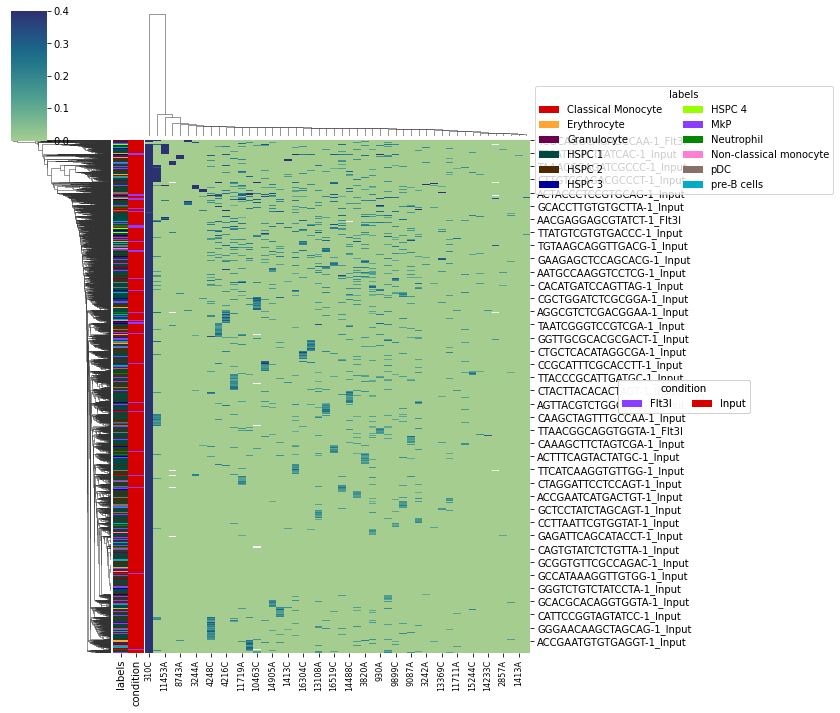

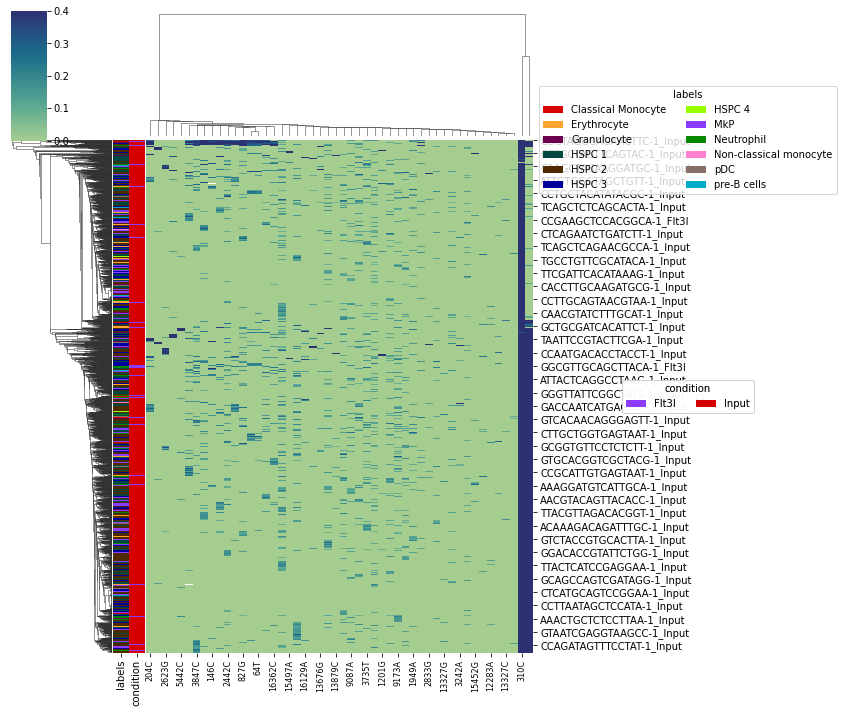

In [19]:
min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("labels")
    af = af.loc[curr_labels_df.index]    
    cov = cov.loc[af.index, af.columns]
    mask = mask.loc[af.index, af.columns] 
    

    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["labels", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    
    
    mask = cov<min_cov
    #af[cov<min_cov] = np.nan
    def set_mask(ser, mask):
        curr = mask.loc[ser.name]
        ser[curr] = pd.NA
        return ser

    af_mask = af.apply(set_mask, args=(mask,) , axis=1)
    curr_labels_df[["labels", "condition"]].to_csv(join(outdir, f"minCov10_donor{d}.labels.csv"))
    np.sqrt(af_mask).to_csv(join(outdir, f"minCov10_donor{d}.af.csv"))
    np.sqrt(af).to_csv(join(outdir, f"minCov10_donor{d}.noMask.af.csv"))
    
    
    fu.helper_save(join(outdir, f"minCov10_donor{d}.af.pdf"))
#colormap.set_bad("black") 


In [20]:
# curr_mt_af = af_d[d].copy()
# curr_mt_af["labels"] = [labels_df.loc[x,"labels"] if x in labels_df.index else None for x in curr_mt_af.index ]
# curr_mt_af["condition"] = [labels_df.loc[x,"condition"] if x in labels_df.index else None for x in curr_mt_af.index ]
# curr_mt_af["donor"] = d
# curr_mt_af = curr_mt_af.reset_index().melt(id_vars=["Cell", "labels", "donor", "condition"], 
#                                            var_name="variant",
#                                            value_name="af")


# count_df = curr_mt_af[curr_mt_af["af"]>af_thresh].groupby(["labels", "variant"]).size().to_frame("ncells").reset_index()
# count_df["log2_ncells"] = np.log2(1+count_df["ncells"])
# vars_order = count_df.groupby("variant").sum()["ncells"].sort_values()[::-1].index
# count_df

NameError: name 'af_thresh' is not defined

In [27]:
bar_df

labels,Classical Monocyte,Erythrocyte,Granulocyte,HSPC 1,HSPC 2,HSPC 3,HSPC 4,MkP,Neutrophil,Non-classical monocyte,pDC,pre-B cells
variant,,,,,,,,,,,,
10397G,1.0,12.0,8.0,58.0,77.0,28.0,1.0,25.0,1.0,NaN,12.0,8.0
1040C,NaN,6.0,4.0,33.0,47.0,13.0,1.0,8.0,5.0,NaN,6.0,NaN
10589A,2.0,15.0,8.0,46.0,68.0,24.0,NaN,19.0,12.0,2.0,9.0,7.0
11761T,2.0,17.0,6.0,59.0,98.0,33.0,1.0,39.0,16.0,2.0,11.0,7.0
11838A,5.0,12.0,13.0,127.0,190.0,69.0,1.0,67.0,19.0,1.0,6.0,8.0
1201G,NaN,NaN,1.0,12.0,17.0,6.0,NaN,6.0,1.0,NaN,2.0,1.0
12283A,1.0,NaN,1.0,8.0,11.0,6.0,NaN,2.0,NaN,NaN,1.0,NaN
12283T,2.0,10.0,8.0,67.0,85.0,33.0,1.0,31.0,6.0,NaN,4.0,5.0
13108A,3.0,10.0,3.0,83.0,95.0,32.0,NaN,49.0,6.0,NaN,3.0,4.0


In [29]:
bar_df.fillna(0).copy().divide(bar_df.fillna(0).sum(axis=1), axis=0)

labels,Classical Monocyte,Erythrocyte,Granulocyte,HSPC 1,HSPC 2,HSPC 3,HSPC 4,MkP,Neutrophil,Non-classical monocyte,pDC,pre-B cells
variant,,,,,,,,,,,,
10397G,0.004329,0.051948,0.034632,0.251082,0.333333,0.121212,0.004329,0.108225,0.004329,0.000000,0.051948,0.034632
1040C,0.000000,0.048780,0.032520,0.268293,0.382114,0.105691,0.008130,0.065041,0.040650,0.000000,0.048780,0.000000
10589A,0.009434,0.070755,0.037736,0.216981,0.320755,0.113208,0.000000,0.089623,0.056604,0.009434,0.042453,0.033019
11761T,0.006873,0.058419,0.020619,0.202749,0.336770,0.113402,0.003436,0.134021,0.054983,0.006873,0.037801,0.024055
11838A,0.009653,0.023166,0.025097,0.245174,0.366795,0.133205,0.001931,0.129344,0.036680,0.001931,0.011583,0.015444
1201G,0.000000,0.000000,0.021739,0.260870,0.369565,0.130435,0.000000,0.130435,0.021739,0.000000,0.043478,0.021739
12283A,0.033333,0.000000,0.033333,0.266667,0.366667,0.200000,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000
12283T,0.007937,0.039683,0.031746,0.265873,0.337302,0.130952,0.003968,0.123016,0.023810,0.000000,0.015873,0.019841
13108A,0.010417,0.034722,0.010417,0.288194,0.329861,0.111111,0.000000,0.170139,0.020833,0.000000,0.010417,0.013889


In [30]:
bar_df.sum(axis=1)

variant
10397G     231.0
1040C      123.0
10589A     212.0
11761T     291.0
11838A     518.0
1201G       46.0
12283A      30.0
12283T     252.0
13108A     288.0
13188T     285.0
13327C      27.0
13327G      42.0
13676G      41.0
13879C      31.0
146C       116.0
14905C      21.0
15297C      42.0
15452G      26.0
15497A      17.0
16129A      46.0
16189C      58.0
16296T    2457.0
16355T     164.0
16362C     184.0
1949A      185.0
196C       131.0
204C       141.0
2442C      279.0
2514A      291.0
2521G      113.0
2623G      108.0
2833G       38.0
310C      2617.0
3242A       23.0
3244A       45.0
3630A      208.0
3735G       27.0
3735T      243.0
3847C      276.0
4248C      354.0
4837A      264.0
5273T      114.0
5442C       40.0
5581G      101.0
58C        151.0
6456A      226.0
64T        150.0
7028G       33.0
7361T      237.0
7598A      190.0
7775A      259.0
827G       229.0
8292A      252.0
8461T      243.0
8770T      190.0
9087A      263.0
9173A      240.0
983T       131.0
9899C 

In [36]:
bar_df.loc[vars_order].divide(bar_df.sum(axis=1),axis=0)

labels,Classical Monocyte,Erythrocyte,Granulocyte,HSPC 1,HSPC 2,HSPC 3,HSPC 4,MkP,Neutrophil,Non-classical monocyte,pDC,pre-B cells
variant,,,,,,,,,,,,
10397G,0.004329,0.051948,0.034632,0.251082,0.333333,0.121212,0.004329,0.108225,0.004329,NaN,0.051948,0.034632
1040C,NaN,0.048780,0.032520,0.268293,0.382114,0.105691,0.008130,0.065041,0.040650,NaN,0.048780,NaN
10589A,0.009434,0.070755,0.037736,0.216981,0.320755,0.113208,NaN,0.089623,0.056604,0.009434,0.042453,0.033019
11761T,0.006873,0.058419,0.020619,0.202749,0.336770,0.113402,0.003436,0.134021,0.054983,0.006873,0.037801,0.024055
11838A,0.009653,0.023166,0.025097,0.245174,0.366795,0.133205,0.001931,0.129344,0.036680,0.001931,0.011583,0.015444
1201G,NaN,NaN,0.021739,0.260870,0.369565,0.130435,NaN,0.130435,0.021739,NaN,0.043478,0.021739
12283A,0.033333,NaN,0.033333,0.266667,0.366667,0.200000,NaN,0.066667,NaN,NaN,0.033333,NaN
12283T,0.007937,0.039683,0.031746,0.265873,0.337302,0.130952,0.003968,0.123016,0.023810,NaN,0.015873,0.019841
13108A,0.010417,0.034722,0.010417,0.288194,0.329861,0.111111,NaN,0.170139,0.020833,NaN,0.010417,0.013889


In [ ]:
bar_df.copy().divide(bar_df.sum(axis=1), axis=0)

,Cell,labels,donor,condition,variant,af
0,AAACGAAAGACGCCAA-1_Input,None,0,None,146A,0.0
1,AAACGAACACGCTCAG-1_Input,MkP,0,Input,146A,0.0
2,AAACGAAGTACCAAGG-1_Input,HSPC 1,0,Input,146A,0.0
3,AAACGAAGTCTGATTG-1_Flt3l,HSPC 3,0,Flt3l,146A,0.0
4,AAACGAAGTTCTCGAA-1_Input,HSPC 2,0,Input,146A,0.0


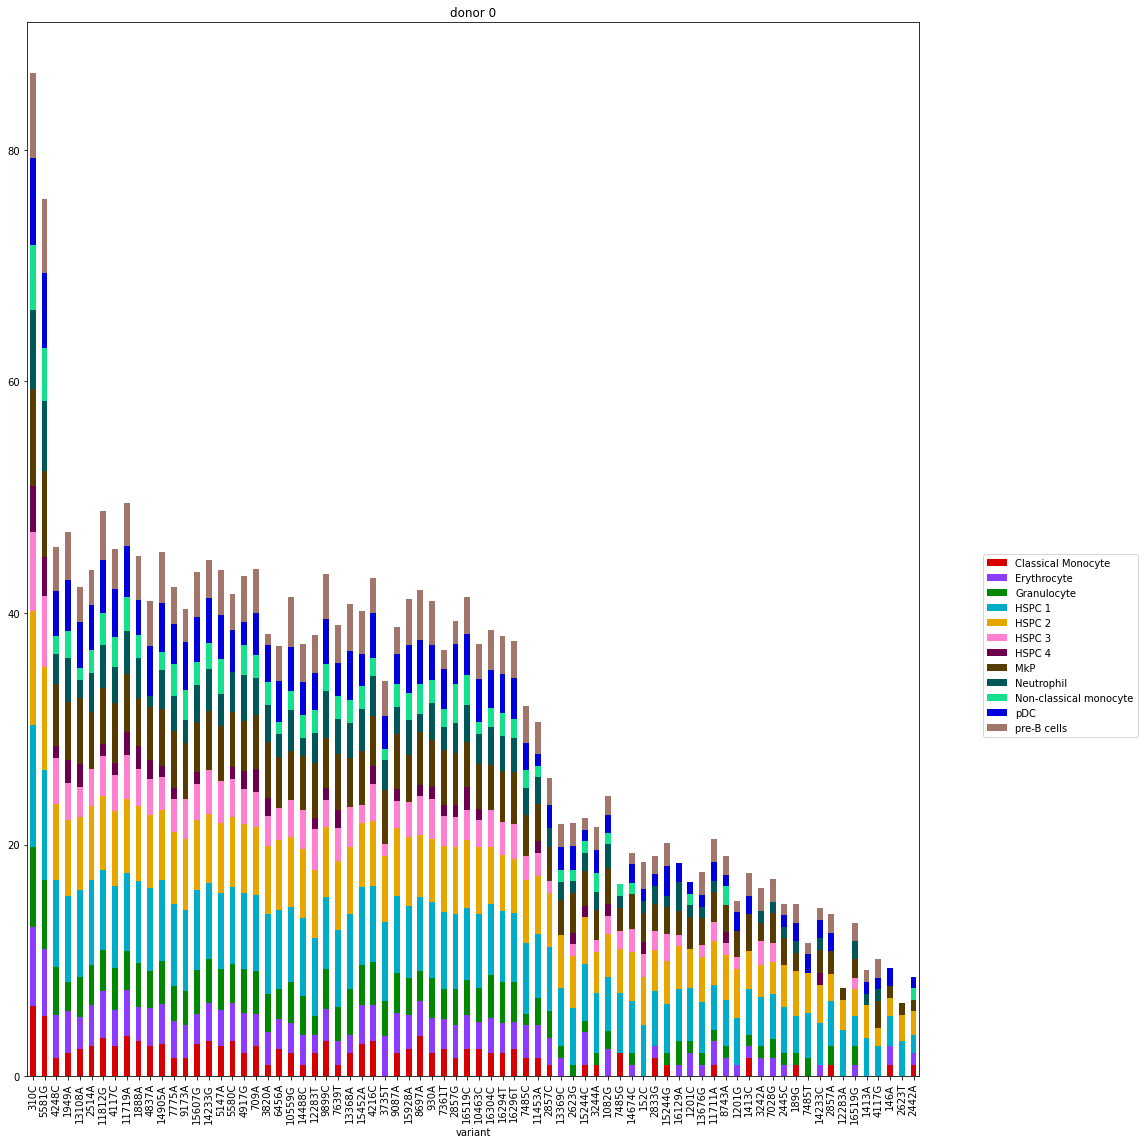

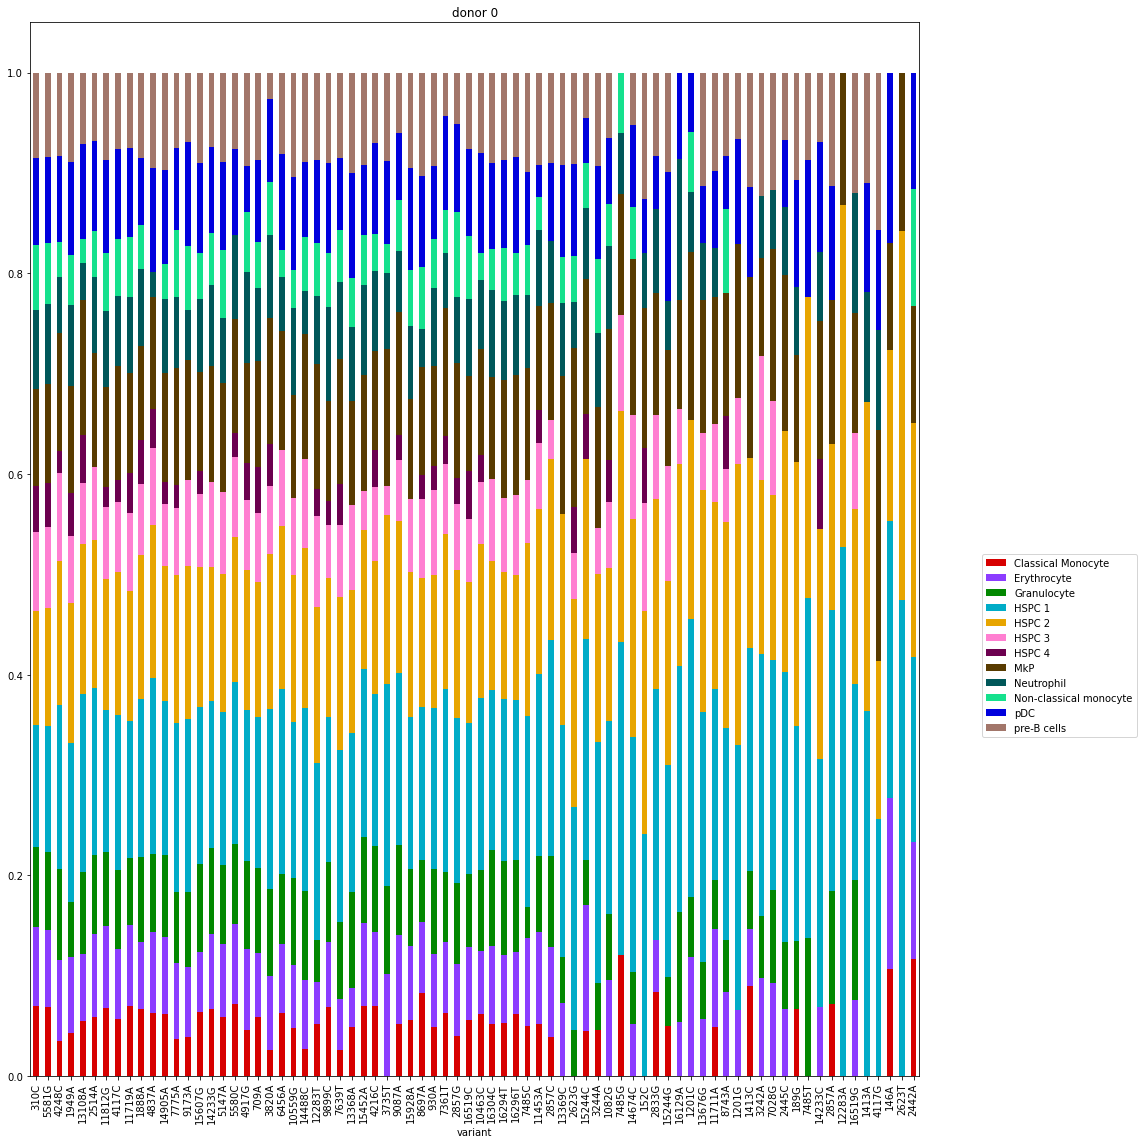

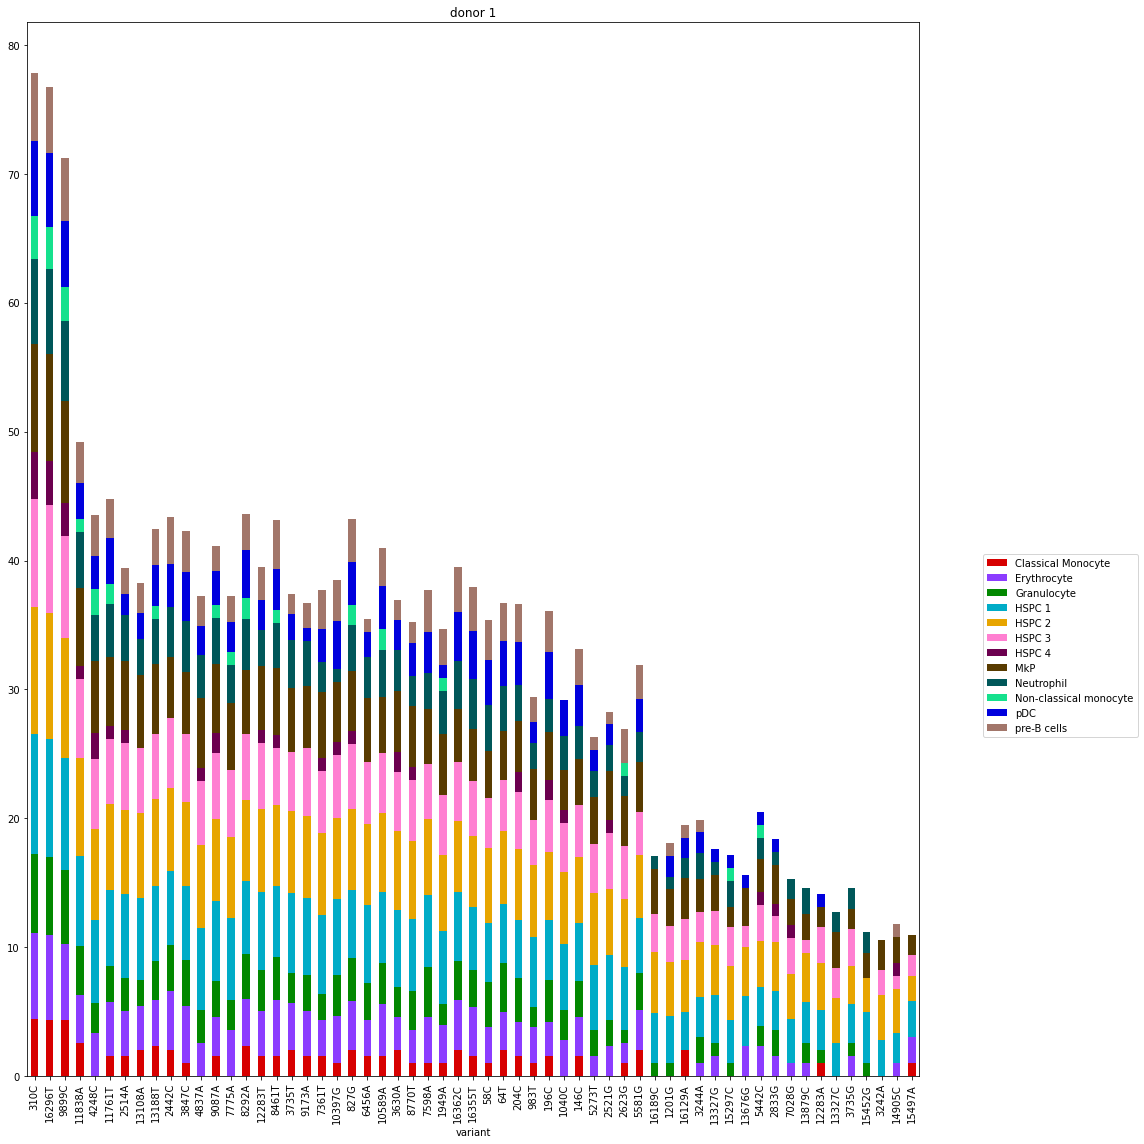

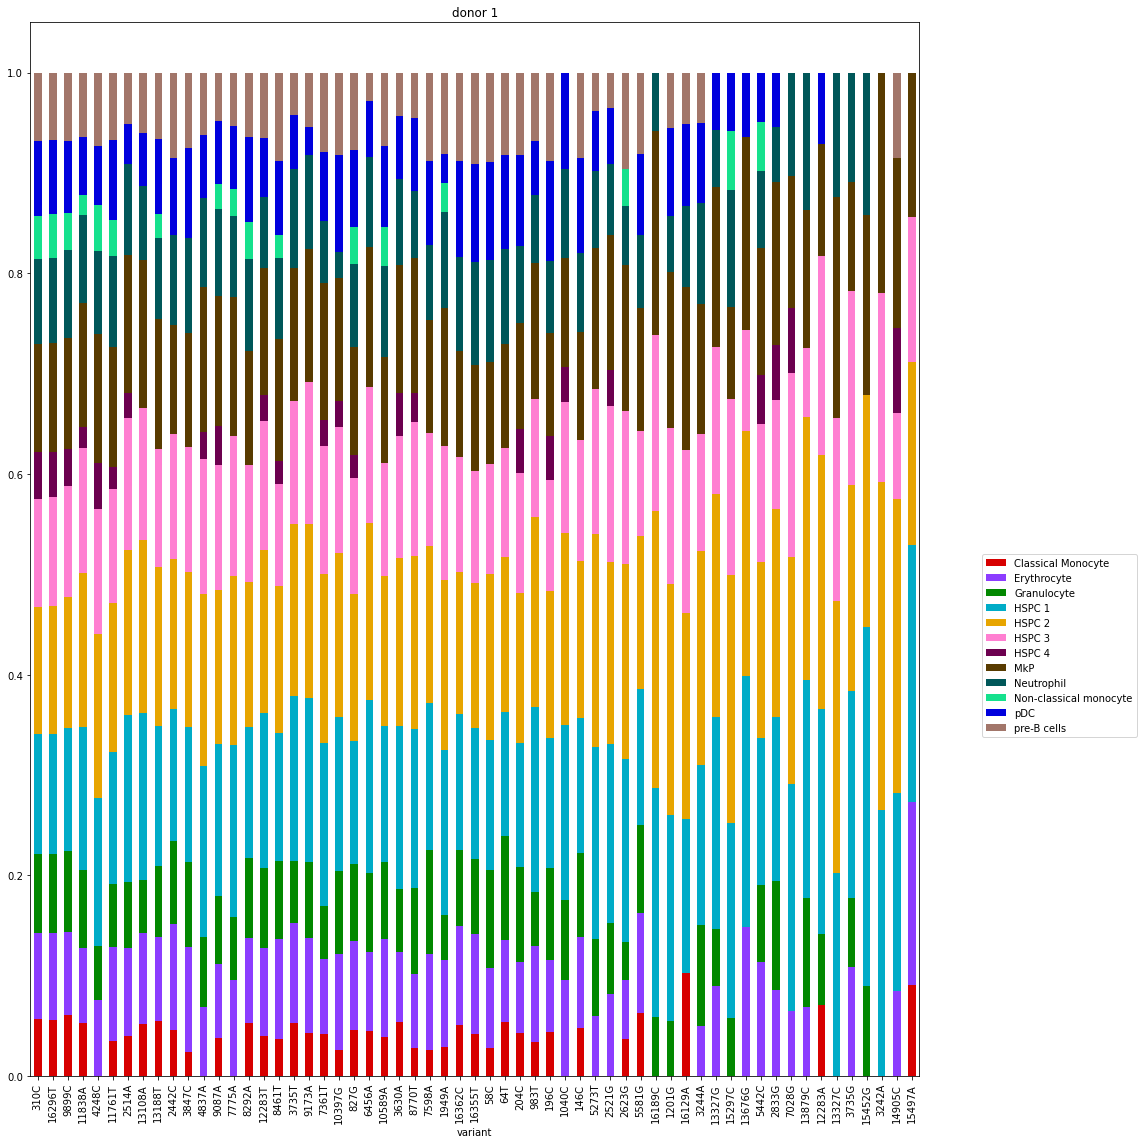

In [45]:
af_thresh=0.01
long_mt_af = []
for d in af_d:
    curr_mt_af = af_d[d].copy()
    curr_mt_af["labels"] = [labels_df.loc[x,"labels"] if x in labels_df.index else None for x in curr_mt_af.index ]
    curr_mt_af["condition"] = [labels_df.loc[x,"condition"] if x in labels_df.index else None for x in curr_mt_af.index ]
    curr_mt_af["donor"] = d
    curr_mt_af = curr_mt_af.reset_index().melt(id_vars=["Cell", "labels", "donor", "condition"], 
                                               var_name="variant",
                                               value_name="af")
    
    
    count_df = curr_mt_af[curr_mt_af["af"]>af_thresh].groupby(["labels", "variant"]).size().to_frame("ncells").reset_index()
    count_df["log2_ncells"] = np.log2(1+count_df["ncells"])
    vars_order = count_df.groupby("variant").sum()["ncells"].sort_values()[::-1].index
    
    f, ax = plt.subplots(figsize=(16,16))
    bar_df = count_df.pivot(index="variant", columns="labels", values="log2_ncells").loc[vars_order]
    bar_df.plot.bar(stacked=True, ax=ax, color=color_d )
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor =(1.25, 0.5))
    plt.title(f"donor {d}")
    plt.tight_layout()
    plt.savefig(join(outdir, f"barcode.clusters.donor{d}.pdf"))
    
    #bar_df = count_df.pivot(index="variant", columns="labels", values="ncells").loc[vars_order]
    bar_df_norm = bar_df.copy().divide(bar_df.sum(axis=1), axis=0)
    f, ax = plt.subplots(figsize=(16,16))
    bar_df_norm.plot.bar(stacked=True, ax=ax, color=color_d)
    plt.xticks(rotation=90)
    plt.title(f"donor {d}")
    plt.legend(bbox_to_anchor =(1.25, 0.5))
    plt.tight_layout()
    plt.savefig(join(outdir, f"barcode.clusters.Norm.donor{d}.pdf"))




    #count_df = curr_mt_af[curr_mt_af["af"]>af_thresh].groupby(["labels", "variant", "condition"]).size().to_frame("ncells").reset_index()
#     g = sns.FacetGrid(data=count_df, col_order=anova_d[d].columns[anova_d[d].columns.isin(count_df["variant"].unique())],
#                       col="variant", hue="condition", 
#                       col_wrap=2, sharey=False, height=4, aspect=2)
#     g.map_dataframe(sns.barplot, x="labels", y="ncells")
#     plt.legend()
#     for ax in g.axes.ravel():
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        
    #curr_mt_af["labels"] = [labels_df.loc[x,"labels"] for x in long_mt_af.index]
    long_mt_af.append(curr_mt_af)
long_mt_af = pd.concat(long_mt_af, axis=0)
long_mt_af.head()



In [ ]:
## Coverage of 50
min_cov50=50
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov50] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("labels")
    af = af.loc[curr_labels_df.index]    
    mask = mask.loc[af.index, af.columns]    
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["labels", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')

#colormap.set_bad("black") 

In [ ]:
### No clustering

min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("labels")
    af = af.loc[curr_labels_df.index]
    
    mask = mask.loc[af.index, af.columns]
    #af = af.loc[af.index.isin(curr_labels_df.index)]
    
    #af[mask] = -1
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["labels", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=False, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    fu.helper_save(join(outdir, f"minCov10_donor{d}.noCluster.af.pdf"))

In [ ]:
#plot_top(af_d[0], cov_d[0], anova_d[0], labels_df, min_cov=2, top_n = 10)

# Sort variants by variance

In [ ]:


# for don, val in long_mt_af.groupby("donor"):
#     vars_order = val.groupby("variant").mean()["af"].sort_values(ascending=False).index.values
#     g = sns.FacetGrid(data=val, col="variant", col_wrap=3, sharex=True, sharey=False, 
#                      height=4, col_order=vars_order, hue="condition")
#     g.map_dataframe(sns.boxenplot, x="labels", y="af")
    

# for don, val in long_mt_af.groupby("donor"):
#     vars_order = val.groupby("variant").mean()["af"].sort_values(ascending=False).index.values
#     g = sns.FacetGrid(data=val, col="variant", col_wrap=3, sharex=True, sharey=False, 
#                      height=4, col_order=vars_order)
#     g.map_dataframe(sns.boxenplot, x="labels", y="af")
    

In [ ]:
# def get_mt_median(curr_df, af_d, labels_df):
#     print(curr_df.name)
#     lab, don = curr_df.name
#     cells = labels_df[(labels_df["donor"]==don) & (labels_df["labels"]==lab)].index
#     curr_af = af_d[int(don)]
#     return curr_af.loc[cells].median(axis=0) #curr_af.loc[curr_af.index.isin(curr_df.index)].median(axis=0)
 
# lin_mt_af = pd.DataFrame(index=labels_df.groupby(["labels", "donor"]).size().index, columns=allVars).apply(get_mt_median, 
#                                                                                                            axis=1, args=(af_d, labels_df))
# lin_mt_af.head()

# def get_cv(x):
#     return np.std(x, ddof=1)/ np.mean(x) * 100


# def order_bar(af, labels, **kwargs):
#     df = pd.DataFrame({"AF":af, "clust": labels}) #, columns=['AF',"clust"])
#     order = labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["labels"]
#     #print(df)
#     #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
#     sns.barplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
#     #sns.boxenplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2])#, hue_order=hue_order)
#     #plt.xticks(rotation=45)
#     return



# for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
#     curr_don_mt = don_lin_mt_af.set_index(["labels","donor"])
#     lin_mt_cv = curr_don_mt.apply(get_cv, axis=0).sort_values(ascending=False)
#     curr_don_mt = curr_don_mt.loc[:,lin_mt_cv.index]

#     lin_mt_af_w = curr_don_mt.iloc[:,:n_vars].reset_index().melt(id_vars=["labels", "donor"], var_name="Variant", value_name="AF")
#     #print(lin_mt_af_w)
#     lin_mt_af_w["donor"] = lin_mt_af_w["donor"].astype(str)
#     lin_mt_af_w["labels"] = lin_mt_af_w["labels"].astype(str)
#     hue_order = lin_mt_af_w["labels"].unique()
#     color_out = create_color_df_v02(lin_mt_af_w, col="labels", clr_type='categorical')
    
# #    g = sns.catplot(x="labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
#  #               sharey=False, sharex=False, hue=None)
#     g = sns.FacetGrid(col="Variant", data=lin_mt_af_w, col_wrap=3, sharex=False, sharey=False, 
#                       hue_order=hue_order,height=4)
#     g.map(order_bar, "AF", "labels")
#     g.set_xticklabels(rotation=90)
#     g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
#     g.fig.tight_layout()